In [ ]:
from google.colab import files
files.upload()

In [2]:
# !pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

The syntax of the command is incorrect.
'cp' is not recognized as an internal or external command,
operable program or batch file.
'chmod' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

In [ ]:
!mkdir data
!unzip -q microsoft-catsvsdogs-dataset.zip -d data/microsoft-catsvsdogs-dataset

In [ ]:
import os,random,shutil
source_dir = "data/microsoft-catsvsdogs-dataset/PetImages"
output_dir = "data/cat-dog-split"

# train and test ratio
train_ratio = 0.8
test_ratio = 0.2

classes = ["Cat","Dog"]

random.seed(42)

for cls in classes:
  cls_path = os.path.join(source_dir,cls)
  images = os.listdir(cls_path)

  # removed corrupted images
  images = [img for img in images if img.endswith(('.png','.jpg','.jpeg'))]

  random.shuffle(images)

  train_count = int(len(images)*train_ratio)

  train_images = images[:train_count]
  test_images = images[train_count:]

  for split in ['train','test']:
    os.makedirs(os.path.join(output_dir,split,cls.lower()),exist_ok=True)

  #copy train
  for img in train_images:
    shutil.copy(
        os.path.join(cls_path,img),
        os.path.join(output_dir,'train',cls.lower(),img)
    )

  #copy test
  for img in test_images:
    shutil.copy(
        os.path.join(cls_path,img),
        os.path.join(output_dir,'test',cls.lower(),img)
    )
  print(f"{cls}: Train={len(train_images)}, Test={len(test_images)}")

print("✅ Done splitting dataset!")


Cat: Train=10000, Test=2500
Dog: Train=10000, Test=2500
✅ Done splitting dataset!


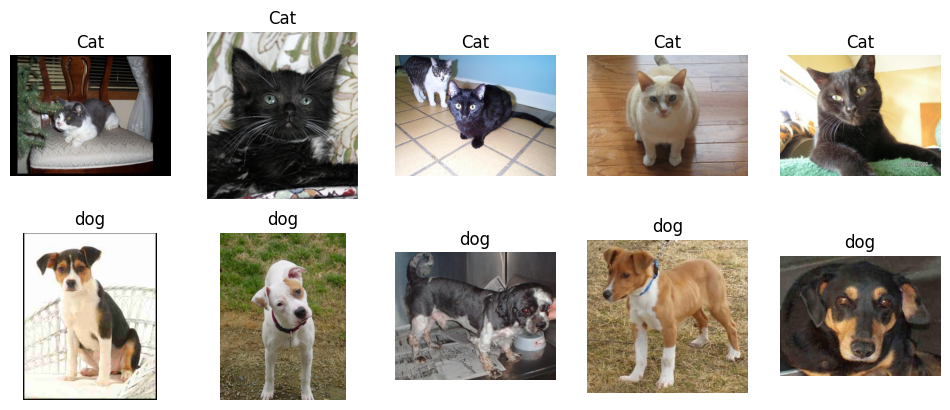

In [ ]:
import os
import matplotlib.pyplot as plt
import  matplotlib.image as mpimg

train_dir = 'data/cat-dog-split/train'
train_cat_dir = os.path.join(train_dir,'cat')
train_dog_dir = os.path.join(train_dir,'dog')

train_cat_fnames = [f for f in os.listdir(train_cat_dir) if f.endswith('.jpg')]
train_dog_fnames = [f for f in os.listdir(train_dog_dir) if f.endswith('.jpg')]

sample_cat_imgs = train_cat_fnames[:5]
sample_dog_imgs = train_dog_fnames[:5]

plt.figure(figsize=(12,10))

for i,img in enumerate(sample_cat_imgs):
  img_path = os.path.join(train_cat_dir,img)
  img = mpimg.imread(img_path)
  plt.subplot(4,5,i+1)
  plt.imshow(img)
  plt.title("Cat")
  plt.axis('off')

for i,img in enumerate(sample_dog_imgs):
  img_path = os.path.join(train_dog_dir,img)
  img = mpimg.imread(img_path)
  plt.subplot(4,5,i+6)
  plt.imshow(img)
  plt.title("dog")
  plt.axis('off')

## Preprocess Images

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import os
from PIL import Image

train_dir = 'data/cat-dog-split/train'
test_dir = 'data/cat-dog-split/test'

# Function to check and remove corrupted images
def remove_corrupted_images(directory):
    print(f"Checking for corrupted images in: {directory}")
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                filepath = os.path.join(root, file)
                try:
                    img = Image.open(filepath)
                    img.verify() # Verify if it's a valid image
                except (IOError, SyntaxError, Image.UnidentifiedImageError) as e:
                    print(f"Deleting corrupted image: {filepath} ({e})")
                    os.remove(filepath)

# Clean up corrupted images in train and test directories
remove_corrupted_images(train_dir)
remove_corrupted_images(test_dir)

#parameters
IMAGE_SIZE = (150,150)
BATCH_SIZE = 32
VALIATION_SPLIT = 0.2

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=VALIATION_SPLIT
)
train_generat = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset = 'training'
)
validation_generat = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)
test_generat = ImageDataGenerator(rescale=(1./255)).flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


print("Data generators created successfully!")
print(f"Found {train_generat.samples} training images belonging to {train_generat.num_classes} classes.")
print(f"Found {validation_generat.samples} validation images belonging to {validation_generat.num_classes} classes.")
print(f"Found {test_generat.samples} testing images belonging to {test_generat.num_classes} classes.")

Checking for corrupted images in: data/cat-dog-split/train


/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Checking for corrupted images in: data/cat-dog-split/test
Found 16000 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Data generators created successfully!
Found 16000 training images belonging to 2 classes.
Found 3998 validation images belonging to 2 classes.
Found 5000 testing images belonging to 2 classes.


## Transfer Learning

In [ ]:
# Load Model
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    input_shape=(150,150,3),
    include_top = False,
    weights='imagenet'
)


/tmp/ipython-input-2179100526.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## No Fine-Tuning

In [ ]:
base_model.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D,Dropout,Dense

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1,activation='sigmoid') #binary classification
])
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_generat,
    validation_data=validation_generat,
    epochs=EPOCHS
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 261ms/step - accuracy: 0.6875 - loss: 2.6246 - val_accuracy: 0.8767 - val_loss: 0.5676
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 127s 255ms/step - accuracy: 0.8324 - loss: 0.9264 - val_accuracy: 0.8924 - val_loss: 0.4150
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 129s 258ms/step - accuracy: 0.8587 - loss: 0.6722 - val_accuracy: 0.9035 - val_loss: 0.3578
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 128s 257ms/step - accuracy: 0.8729 - loss: 0.5599 - val_accuracy: 0.9050 - val_loss: 0.3755
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 129s 257ms/step - accuracy: 0.8798 - loss: 0.4992 - val_accuracy: 0.9090 - val_loss: 0.3004
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 261ms/step - accuracy: 0.8797 - loss: 0.4780 - val_accuracy: 0.9130 - val_loss: 0.2821
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 265ms/step - accuracy: 0.8880 - loss: 0.4007 - val_accuracy: 0.9227 - val_loss: 0.2522
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 262ms/step - accuracy: 0.8907 -

In [ ]:
test_loss, test_acc = model.evaluate(test_generat)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"📉 Test Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.9404 - loss: 0.1882

✅ Test Accuracy: 0.8590
📉 Test Loss: 0.4496


## Fine-Tuning

In [ ]:
from tensorflow.keras import Input, layers,Model

inputs = Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model2 = Model(inputs, outputs)

In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = len(base_model.layers)-30  # last 30
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

print(f"✅ Total MobileNetV2 layers: {len(base_model.layers)}")
print(f"🔓 Fine-tuning from layer: {fine_tune_at}")

✅ Total MobileNetV2 layers: 154
🔓 Fine-tuning from layer: 124


In [ ]:
model2.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

history_phase2 = model2.fit(
    train_generat,
    validation_data=validation_generat,
    epochs=10
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 155s 279ms/step - accuracy: 0.8118 - loss: 0.3942 - val_accuracy: 0.9447 - val_loss: 0.1495
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 275ms/step - accuracy: 0.9428 - loss: 0.1384 - val_accuracy: 0.9635 - val_loss: 0.0931
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 260ms/step - accuracy: 0.9561 - loss: 0.1087 - val_accuracy: 0.9657 - val_loss: 0.0803
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 133s 266ms/step - accuracy: 0.9619 - loss: 0.0965 - val_accuracy: 0.9682 - val_loss: 0.0779
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 133s 265ms/step - accuracy: 0.9662 - loss: 0.0850 - val_accuracy: 0.9735 - val_loss: 0.0713
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 262ms/step - accuracy: 0.9683 - loss: 0.0856 - val_accuracy: 0.9740 - val_loss: 0.0637
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 261ms/step - accuracy: 0.9675 - loss: 0.0777 - val_accuracy: 0.9732 - val_loss: 0.0669
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 131s 262ms/step - accuracy: 0.9744 -

In [ ]:
test_loss, test_acc = model.evaluate(test_generat)

print("\n✅ FINAL RESULTS 🎉")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9185 - loss: 0.2228

✅ FINAL RESULTS 🎉
Test Accuracy: 0.9224
Test Loss: 0.2092


### Upload your image to test

In [ ]:
from google.colab import files
import io

uploaded = files.upload()

# Get the filename of the uploaded image
for fn in uploaded.keys():
  uploaded_image_filename = fn

print(f"Uploaded file: {uploaded_image_filename}")

Saving cat.webp to cat (2).webp
Uploaded file: cat (2).webp


### Preprocess and Predict with both models

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


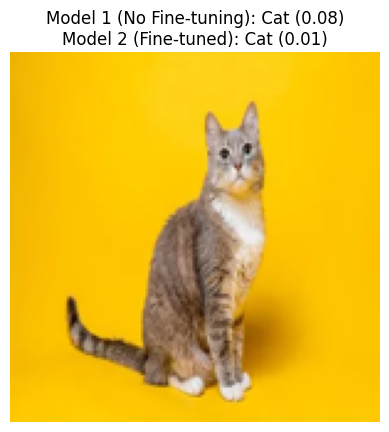


--- Prediction Details ---
Model 1 (No Fine-tuning):
  Probability: 0.0821
  Predicted Class: Cat

Model 2 (Fine-tuned):
  Probability: 0.0075
  Predicted Class: Cat


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Load and preprocess the uploaded image
img = Image.open(io.BytesIO(uploaded[uploaded_image_filename]))
img = img.resize(IMAGE_SIZE) # Resize to (150, 150)
img_array = np.array(img) # Convert to numpy array
img_array = np.expand_dims(img_array, axis=0) # Add batch dimension
img_array_preprocessed = preprocess_input(img_array.copy()) # Preprocess for MobileNetV2

# Make prediction with model (no fine-tuning)
prediction_model1 = model.predict(img_array_preprocessed)
prediction_class_model1 = (prediction_model1 > 0.5).astype("int32")[0][0]
prediction_proba_model1 = prediction_model1[0][0]

# Make prediction with model2 (fine-tuned)
prediction_model2 = model2.predict(img_array_preprocessed)
prediction_class_model2 = (prediction_model2 > 0.5).astype("int32")[0][0]
prediction_proba_model2 = prediction_model2[0][0]

# Display the image and predictions
plt.imshow(img)
plt.title(f"Model 1 (No Fine-tuning): {'Dog' if prediction_class_model1 == 1 else 'Cat'} ({prediction_proba_model1:.2f})\nModel 2 (Fine-tuned): {'Dog' if prediction_class_model2 == 1 else 'Cat'} ({prediction_proba_model2:.2f})")
plt.axis('off')
plt.show()

print("\n--- Prediction Details ---")
print(f"Model 1 (No Fine-tuning):")
print(f"  Probability: {prediction_proba_model1:.4f}")
print(f"  Predicted Class: {'Dog' if prediction_class_model1 == 1 else 'Cat'}")

print(f"\nModel 2 (Fine-tuned):")
print(f"  Probability: {prediction_proba_model2:.4f}")
print(f"  Predicted Class: {'Dog' if prediction_class_model2 == 1 else 'Cat'}")

### Generate Predictions for Both Models

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Get true labels from the test generator
true_labels = test_generat.classes

# Predict probabilities for model (no fine-tuning)
predictions_model1_proba = model.predict(test_generat)
predictions_model1 = (predictions_model1_proba > 0.5).astype(int)

# Predict probabilities for model2 (fine-tuned)
predictions_model2_proba = model2.predict(test_generat)
predictions_model2 = (predictions_model2_proba > 0.5).astype(int)

print("Predictions generated successfully!")

157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 84ms/step
Predictions generated successfully!


### Confusion Matrix and Classification Report for Model 1 (No Fine-tuning)

In [ ]:
print("--- Model 1 (No Fine-tuning) Evaluation ---")
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions_model1))
print("\nClassification Report:")
print(classification_report(true_labels, predictions_model1, target_names=['cat', 'dog']))

--- Model 1 (No Fine-tuning) Evaluation ---
Confusion Matrix:
[[2292  208]
 [ 180 2320]]

Classification Report:
              precision    recall  f1-score   support

         cat       0.93      0.92      0.92      2500
         dog       0.92      0.93      0.92      2500

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000



### Confusion Matrix and Classification Report for Model 2 (Fine-tuned)

### Visualize Confusion Matrix for Model 1 (No Fine-tuning)

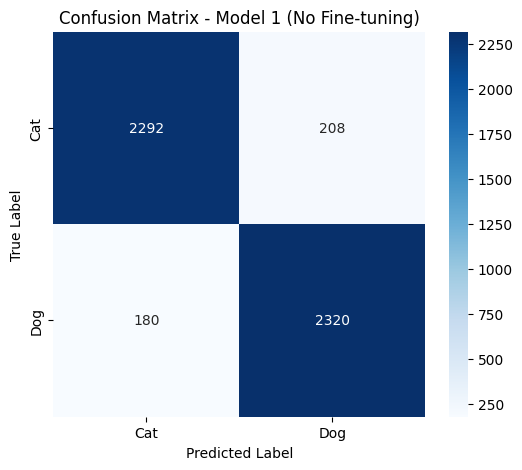

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(true_labels, predictions_model1)
plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix - Model 1 (No Fine-tuning)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Visualize Confusion Matrix for Model 2 (Fine-tuned)

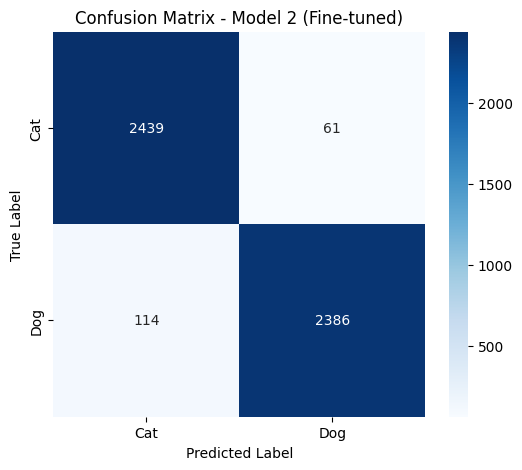

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm2 = confusion_matrix(true_labels, predictions_model2)
plt.figure(figsize=(6, 5))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix - Model 2 (Fine-tuned)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print("--- Model 2 (Fine-tuned) Evaluation ---")
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predictions_model2))
print("\nClassification Report:")
print(classification_report(true_labels, predictions_model2, target_names=['cat', 'dog']))

--- Model 2 (Fine-tuned) Evaluation ---
Confusion Matrix:
[[2439   61]
 [ 114 2386]]

Classification Report:
              precision    recall  f1-score   support

         cat       0.96      0.98      0.97      2500
         dog       0.98      0.95      0.96      2500

    accuracy                           0.96      5000
   macro avg       0.97      0.97      0.96      5000
weighted avg       0.97      0.96      0.96      5000



In [ ]:
test_loss_model2, test_acc_model2 = model2.evaluate(test_generat)

print(f"\n✅ Model 2 (Fine-tuned) Test Accuracy: {test_acc_model2:.4f}")
print(f"📉 Model 2 (Fine-tuned) Test Loss: {test_loss_model2:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.9730 - loss: 0.0729

✅ Model 2 (Fine-tuned) Test Accuracy: 0.9650
📉 Model 2 (Fine-tuned) Test Loss: 0.0916
